In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Data processing

In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df_copy = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99826 non-null  object 
 1   category       99826 non-null  object 
 2   title          99826 non-null  object 
 3   body           99812 non-null  object 
 4   amenities      83749 non-null  object 
 5   bathrooms      99760 non-null  object 
 6   bedrooms       99699 non-null  object 
 7   currency       99822 non-null  object 
 8   fee            99823 non-null  object 
 9   has_photo      99823 non-null  object 
 10  pets_allowed   39192 non-null  object 
 11  price          99821 non-null  float64
 12  price_display  99820 non-null  object 
 13  price_type     99823 non-null  object 
 14  square_feet    99823 non-null  object 
 15  address        7946 non-null   object 
 16  cityname       99521 non-null  object 
 17  state          99521 non-null  object 
 18  latitu

In [4]:
df_copy = df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99826 non-null  object 
 1   category       99826 non-null  object 
 2   title          99826 non-null  object 
 3   body           99812 non-null  object 
 4   amenities      83749 non-null  object 
 5   bathrooms      99760 non-null  object 
 6   bedrooms       99699 non-null  object 
 7   currency       99822 non-null  object 
 8   fee            99823 non-null  object 
 9   has_photo      99823 non-null  object 
 10  pets_allowed   39192 non-null  object 
 11  price          99821 non-null  float64
 12  price_display  99820 non-null  object 
 13  price_type     99823 non-null  object 
 14  square_feet    99823 non-null  object 
 15  address        7946 non-null   object 
 16  cityname       99521 non-null  object 
 17  state          99521 non-null  object 
 18  latitu

In [6]:
# Drop unecessary columns:
df = df.drop(columns=["id","category","title","body","time","address","currency","price_display", "source"])

In [7]:
df.columns

Index(['amenities', 'bathrooms', 'bedrooms', 'fee', 'has_photo',
       'pets_allowed', 'price', 'price_type', 'square_feet', 'cityname',
       'state', 'latitude', 'longitude'],
      dtype='object')

In [8]:
# Fillan the 'amenities' columns with 'No amenities'
df['amenities'] =  df['amenities'].fillna("No amenities")

# Split values in the 'amenities' column:
test = set()
for value in df['amenities'].unique():
    temp = value.split(",")
    for var in temp:
        test.add(var)

# Create separate columns for each amenity: 0 = does not have that amenity, 1 = has that amenity
for column in test:
    df[column] = df['amenities'].apply(lambda x: 1 if column in x else 0)

# Drop unecessary columns after splitting and creating new columns:
df = df.drop(columns=['amenities','No','USD'])


In [9]:
# Fillan the 'pets_allowed' column
df['pets_allowed'] = df['pets_allowed'].fillna("No")
df['pets_allowed'].isna().sum()

0

In [10]:
# Drop 'NA' for all columns in the dataframe:
df = df.dropna()

In [11]:
df = df[df['bathrooms']!="Thumbnail"]
df = df[df['bedrooms']!="Thumbnail"]
df = df[df['fee'].isin(["Yes", "No"])]
df = df[df['price_type'] != 'Weekly']
df['has_photo'] = df['has_photo'].replace({"Thumbnail":"No"})
df['pets_allowed'] = df['pets_allowed'].apply(lambda x: 1 if "Cats" in x or "Dogs" in x else 0)

In [12]:
# Subset data: Apartments in "Texas", less than 2000
mask_ba = df["state"].str.contains("TX")
mask_price = df["price"] < 2000
df = df[mask_ba & mask_price]

In [13]:
class ClusteredFeatures:
    
    def __init__(self, add_constant=False):
        self.add_constant=add_constant
        self.dbscan=None
        self.result = None

    def get_coor(self, df):
        return np.radians(df[['latitude', 'longitude']])
    
    def fit_predict(self, df, eps, min_samples):
        x = self.get_coor(df)
        self.dbscan = DBSCAN(eps = eps/6371, min_samples = min_samples,  metric = 'haversine')
        self.result = self.dbscan.fit_predict(x)
    
    def transform(self, df):
        assert self.dbscan is not None, 'You have to call fit before transform!'
        
        # Cluster assignments from DBSCAN
        assignments = self.result

        # Add cluster assignment to the DataFrame
        df_with_clusters = df.copy()
        df_with_clusters['cluster'] = assignments
        
        # Print the mapping of clusters to city names
        self.map_clusters_to_cities(df_with_clusters)
        
        # Optionally add constant terms (dummy variables) for each cluster
        if self.add_constant:
            for cluster_id in np.unique(assignments):
                cluster_column = np.where(assignments == cluster_id, 1, 0)
                df_with_clusters[f'cluster_{cluster_id}'] = cluster_column

        df_with_clusters = df_with_clusters.drop(columns='cluster_-1')
        return df_with_clusters
    
    def map_clusters_to_cities(self, df_with_clusters):
        # Group by cluster and aggregate city names
        cluster_city_mapping = df_with_clusters.groupby('cluster')['cityname'].apply(lambda x: ', '.join(x.unique())).reset_index()
        cluster_city_mapping.columns = ['cluster', 'cityname']

        # Print the mapping of clusters to city names
        for _, row in cluster_city_mapping.iterrows():
            print(f"Cluster {row['cluster']}: {row['cityname']}")
        
    def fit_transform(self, df, eps, min_samples):
        self.fit_predict(df, eps=eps, min_samples=min_samples)
        return self.transform(df)

In [14]:
df_clustered = df.copy()
cluster = ClusteredFeatures(add_constant=True)
df_clustered = cluster.fit_transform(df_clustered, eps =50, min_samples = 10)
df_clustered.info()

Cluster -1: Amarillo, El Paso, Dumas, Pampa, Wichita Falls, Paris, Waco, Henrietta, Early, Brownwood, Dalhart, Victoria, Kerrville, Laredo, Beeville
Cluster 0: San Antonio, Austin, Round Rock, Georgetown, Cedar Park, Blanco, Leander, Pflugerville, Horseshoe Bay, Cameron, New Braunfels, San Marcos, Converse, Bastrop, Lytle, Giddings, Helotes, Universal City, Canyon Lake, Selma, Liberty Hill, Lakeway, Sunset Valley, Leon Valley, Castle Hills, Cibolo, Kyle, Live Oak, Taylor, Pleasanton, Harker Heights, Lockhart, Temple, Killeen, Hutto, Schertz, Seguin
Cluster 1: Orange, Port Arthur, West Orange, Vidor, Beaumont, Sour Lake, Bridge City, Groves
Cluster 2: Houston, Pearland, Humble, Cypress, Baytown, Sugar Land, Missouri City, Spring, Richmond, Crosby, Channelview, League City, Tomball, Willis, Montgomery, Galveston, Pasadena, Porter, Katy, Kingwood, Webster, Rosenberg, Bacliff, Angleton, Alvin, Lake Jackson, Clute, Seabrook, Bay City, Conroe, Stafford, Huntsville, Cleveland, Freeport, Magno

In [15]:
for column in df_clustered.columns: 
    if column in ['bathrooms','bedrooms', 'price','latitude','longitude', 'square_feet']:
        df[column] = df[column].astype('float')


In [16]:
df_clustered.columns

Index(['bathrooms', 'bedrooms', 'fee', 'has_photo', 'pets_allowed', 'price',
       'price_type', 'square_feet', 'cityname', 'state', 'latitude',
       'longitude', 'TV', 'Internet Access', 'Hot Tub', 'Gym', 'AC', 'Pool',
       'Elevator', 'Fireplace', 'Alarm', 'View', 'Doorman',
       'Cable or Satellite', 'Storage', 'Playground', 'Clubhouse',
       'Dishwasher', 'Basketball', 'No amenities', 'Washer Dryer', 'Gated',
       'Refrigerator', 'Golf', 'Luxury', 'Garbage Disposal', 'Tennis',
       'Patio/Deck', 'Parking', 'Wood Floors', 'cluster', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10',
       'cluster_11'],
      dtype='object')

#### 2. Exploratory Data Analysis

2.1 Statistics and Distribution

In [17]:
df.describe()

,bathrooms,bedrooms,pets_allowed,price,square_feet,latitude,longitude,TV,Internet Access,Hot Tub,...,Washer Dryer,Gated,Refrigerator,Golf,Luxury,Garbage Disposal,Tennis,Patio/Deck,Parking,Wood Floors
count,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,...,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000
mean,1.379775,1.558788,0.404499,1163.117390,880.340087,31.869706,-96.840545,0.036063,0.110977,0.043127,...,0.311088,0.122130,0.160796,0.000186,0.001952,0.048796,0.038758,0.261548,0.486755,0.081327
std,0.502294,0.684637,0.490818,320.417962,289.490144,1.541737,0.978930,0.186455,0.314118,0.203152,...,0.462960,0.327451,0.367359,0.013634,0.044139,0.215452,0.193027,0.439498,0.499848,0.273350
min,1.000000,0.000000,0.000000,300.000000,200.000000,26.159600,-106.445000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,920.000000,683.000000,30.305400,-97.103900,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1120.000000,810.000000,32.782600,-96.838700,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1375.000000,1041.000000,32.918600,-96.661500,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,3.500000,5.000000,1.000000,1999.000000,3475.000000,36.065600,-93.758100,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


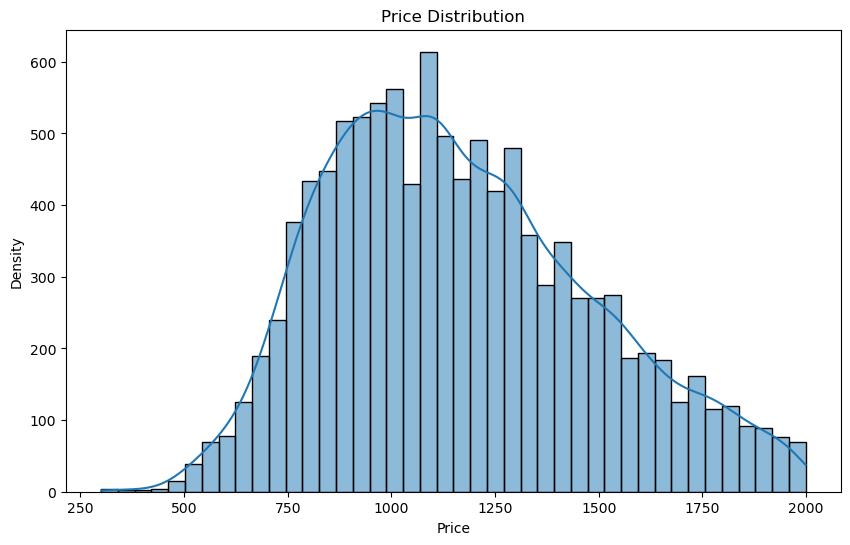

In [18]:
# Histogram of the numerical feature 'price'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(data=df, x='price', kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

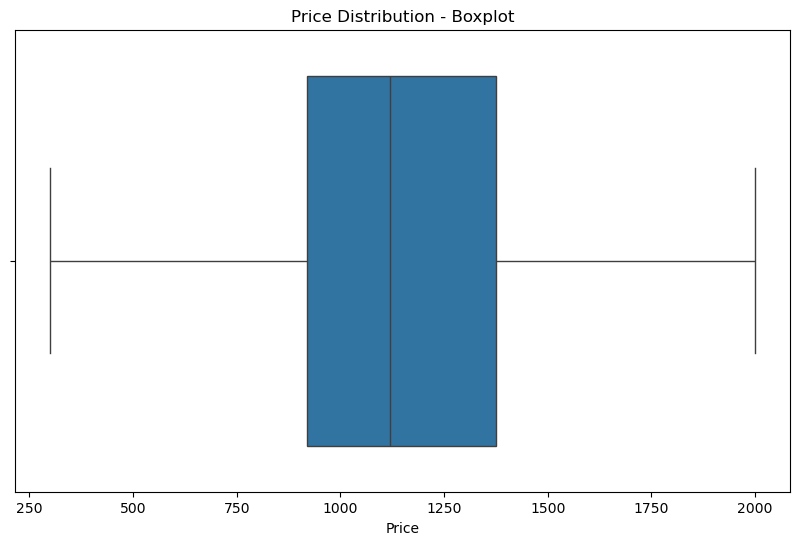

In [19]:
# Boxplot of the numerical feature 'price'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(data=df, x='price')
plt.title('Price Distribution - Boxplot')
plt.xlabel('Price')
plt.show()

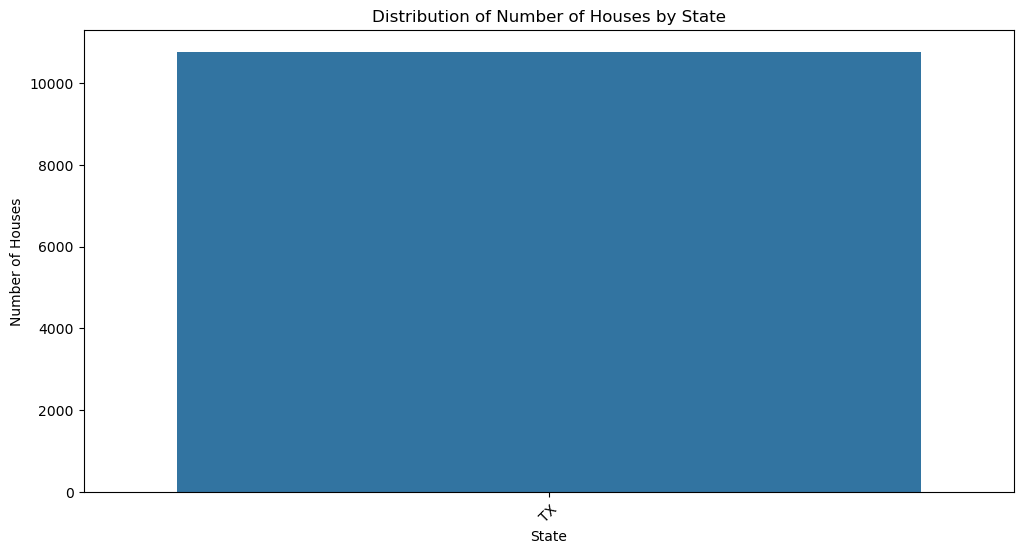

In [20]:
# Bar plot of number of houses by state
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.countplot(data=df, x='state', order=df['state'].value_counts().index)
plt.title('Distribution of Number of Houses by State')
plt.xlabel('State')
plt.ylabel('Number of Houses')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


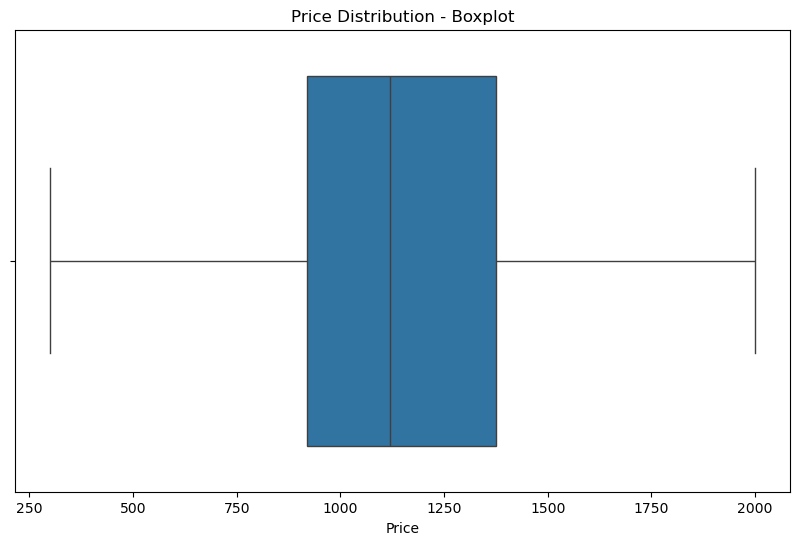

In [21]:
# Boxplot of the 'price' in CA
data_CA = df[df['state'] == 'TX']
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(data= data_CA, x='price')
plt.title('Price Distribution - Boxplot')
plt.xlabel('Price')
plt.show()

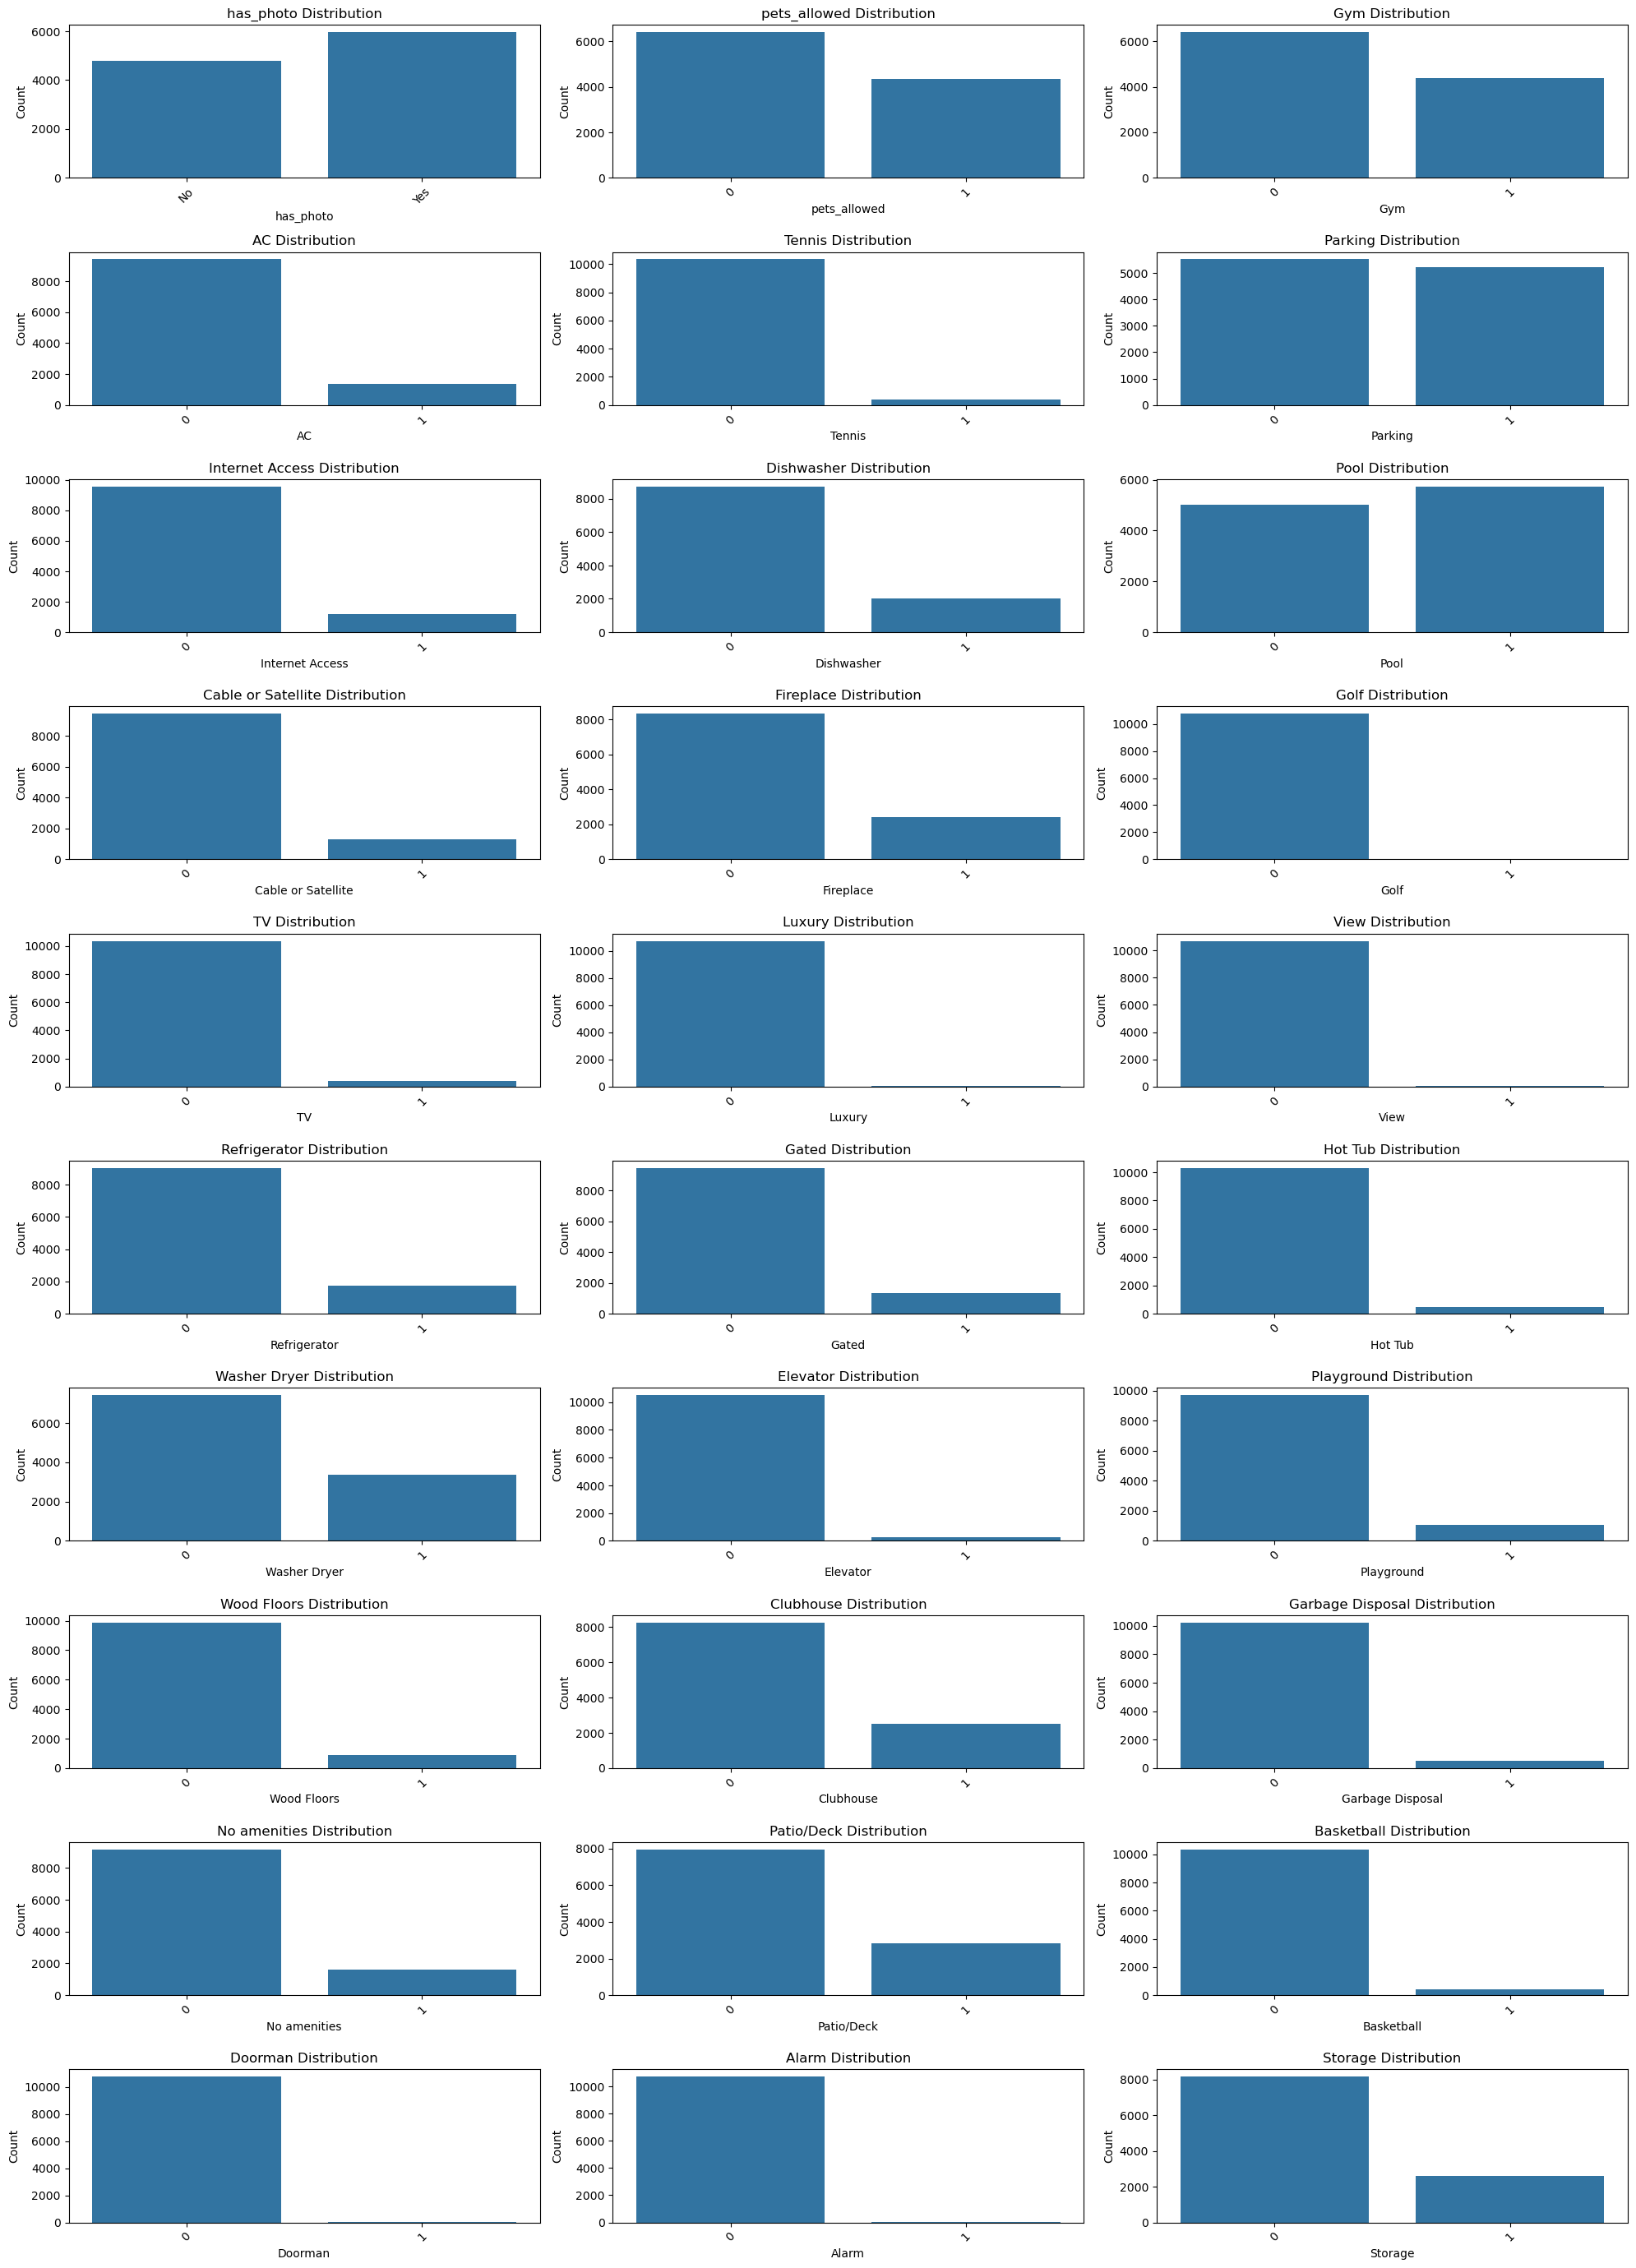

In [22]:
# Categorical columns
categorical_features = ['has_photo', 'pets_allowed', 'Gym', 'AC', 'Tennis', 'Parking',
       'Internet Access', 'Dishwasher', 'Pool', 'Cable or Satellite',
       'Fireplace', 'Golf', 'TV', 'Luxury', 'View', 'Refrigerator', 'Gated',
       'Hot Tub', 'Washer Dryer', 'Elevator', 'Playground', 'Wood Floors',
       'Clubhouse', 'Garbage Disposal', 'No amenities', 'Patio/Deck',
       'Basketball', 'Doorman', 'Alarm', 'Storage']

# Create a figure with a larger grid size
plt.figure(figsize=(20, 30))  # Adjust figure size to be large enough
total_features = len(categorical_features)

# Set up the grid size dynamically based on the number of features
for i, feature in enumerate(categorical_features, 1):
    plt.subplot((total_features // 3) + 1, 3, i)
    sns.countplot(data=df, x=feature)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

# Ensure the layout is adjusted for all plots to fit
plt.tight_layout()
plt.show();


In [23]:
'''import plotly.express as px
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='latitude',
    lon='longitude',
    size="price",
    center={"lat": 39.8283, "lon": -98.5795},  # Map will be centered on Helsinki
    width=1000,  # Width of map
    height=700,  # Height of map
    size_max=20,
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()'''

'import plotly.express as px\nfig = px.scatter_mapbox(\n    df,  # Our DataFrame\n    lat=\'latitude\',\n    lon=\'longitude\',\n    size="price",\n    center={"lat": 39.8283, "lon": -98.5795},  # Map will be centered on Helsinki\n    width=1000,  # Width of map\n    height=700,  # Height of map\n    size_max=20,\n)\n\nfig.update_layout(mapbox_style="open-street-map")\n\nfig.show()'

##### 2.2 Correlation heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

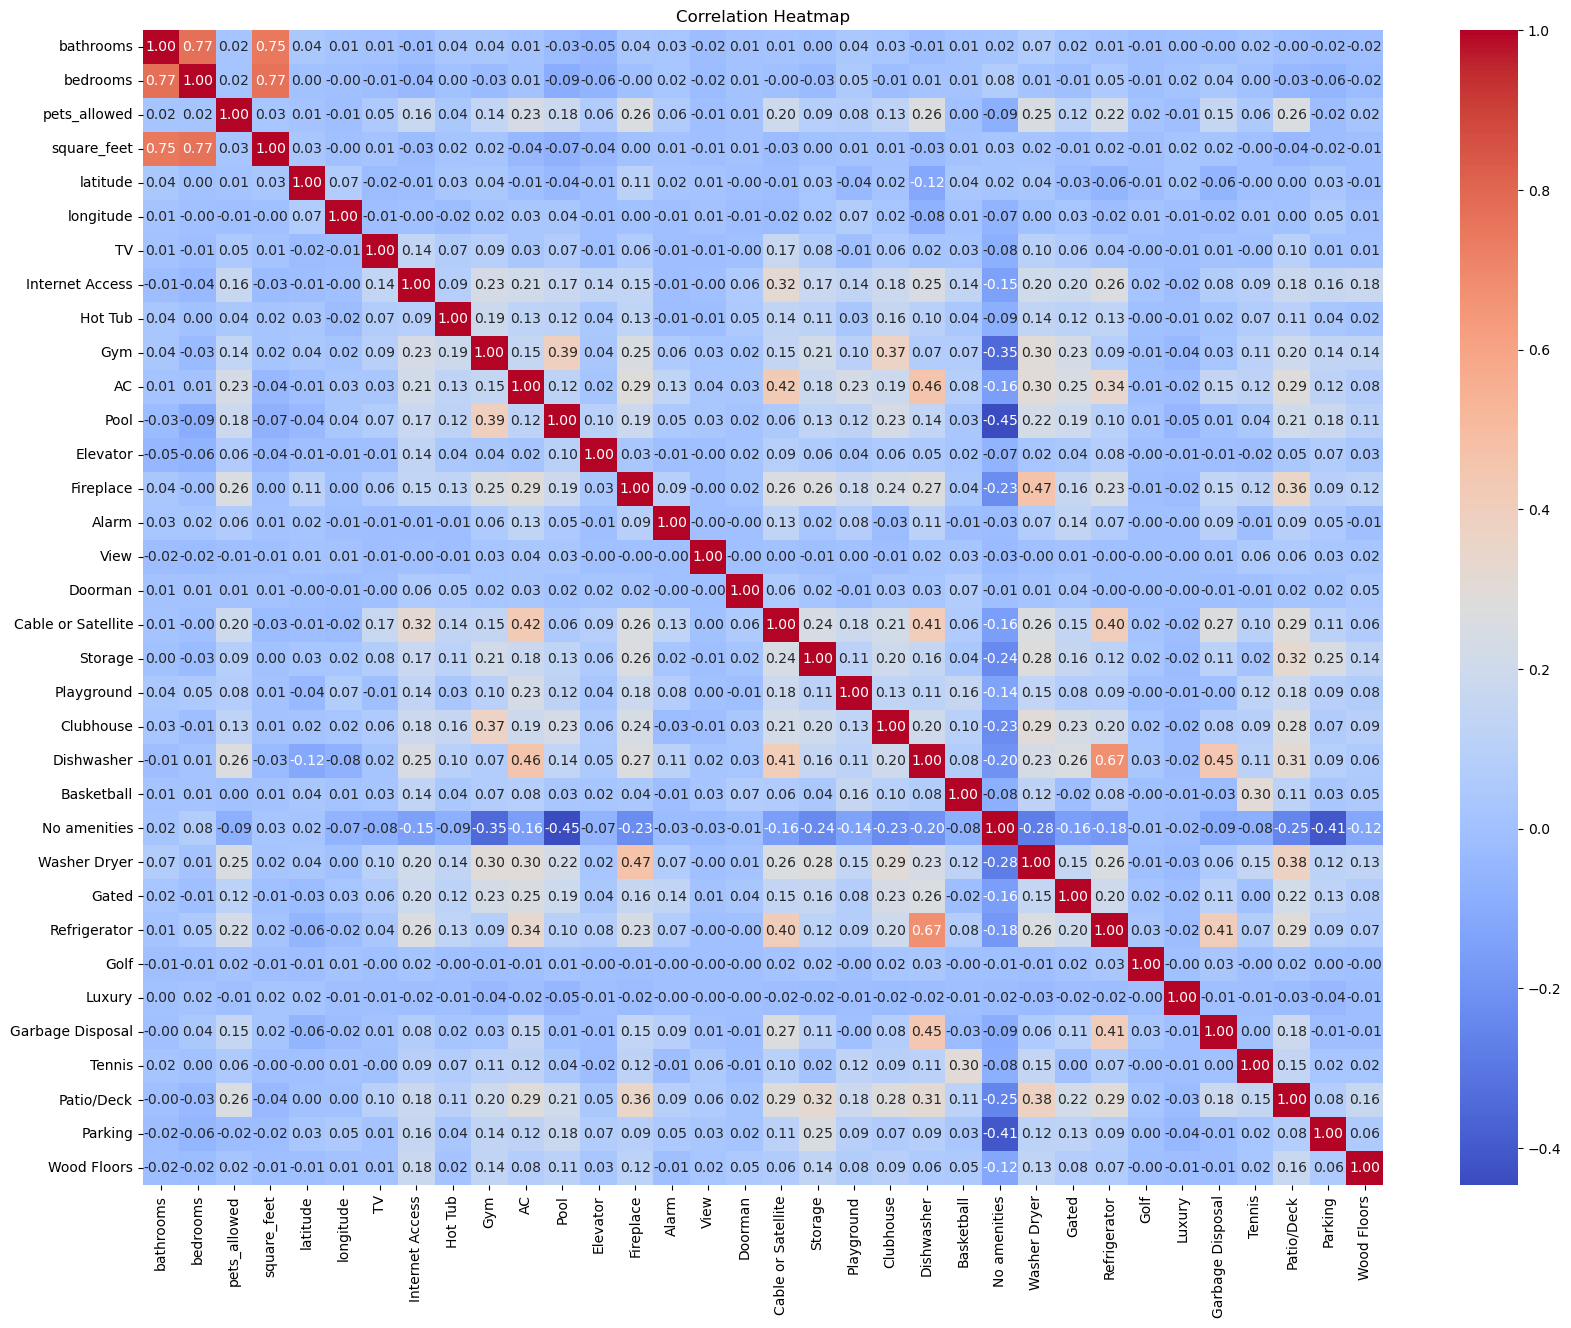

In [24]:
corr = df.select_dtypes("number").drop(columns="price").corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

#### 3. Modeling - Regression:

In [25]:
# Splite the model into training, test and validation set
X = df_clustered.drop(columns=['price','state','longitude','latitude','cityname']).copy()
X = pd.get_dummies(X, columns=['fee','has_photo','pets_allowed','price_type'], drop_first=True)
y = df_clustered['price'].copy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [26]:
Regression_comparision = {}

In [27]:
#Linear regression
lr_benchmark = LinearRegression()
lr_benchmark.fit(X_train, y_train)

y_pred = lr_benchmark.predict(X_val)

r2 = lr_benchmark.score(X_val, y_val)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)


Regression_comparision['LinearRegression_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [44]:
# Test error with tesing data 

MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)


Regression_comparision['LinearRegression_final'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [29]:
#Ridge
ridge_benchmark = Ridge()
ridge_benchmark.fit(X_train, y_train)

y_pred = ridge_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Ridge_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [30]:
#Lasso
lasso_benchmark = Lasso()
lasso_benchmark.fit(X_train, y_train)

y_pred = lasso_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Lasso_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

#### 4. Hyperparameter tunning

In [31]:
# Randomized Grid Search parameters for Lasso
param_grid = {
        'alpha': np.linspace(0.01, 50, 200), 
        'max_iter' : [1000,2000,3000,4000,5000],
    }

rcv = RandomizedSearchCV(Lasso(), param_grid, n_iter=100)
rcv.fit(X_train, y_train)

lasso_rgs = Lasso(**rcv.best_params_)
lasso_rgs.fit(X_train, y_train)

y_pred = lasso_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Lasso_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [32]:
# Randomized Grid Search parameters for Ridge
param_grid = {
        'alpha': np.linspace(0.01, 50, 200), 
        'max_iter' : [1000,2000,3000,4000,5000],
    }

rcv = RandomizedSearchCV(Ridge(), param_grid, n_iter=100)
rcv.fit(X_train, y_train)

ridge_rgs = Ridge(**rcv.best_params_)
ridge_rgs.fit(X_train, y_train)

y_pred = lasso_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Ridge_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [45]:
# Standardize data for improving model performance

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_val_scaled = scaler.transform(X_val)

#Linear regression
lr_scaler = MLPRegressor()
lr_scaler.fit(X_train_scaled, y_train)

y_pred = lr_scaler.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)


Regression_comparision['MLP_StandardScaler'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

/opt/software/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### 5. Model evaluation

In [34]:
results = pd.DataFrame(Regression_comparision)
results

,LinearRegression_benchmark,LinearRegression_final,Ridge_benchmark,Lasso_benchmark,Lasso_rgs,Ridge_rgs,MLP_StandardScaler
r2,0.506752,0.506752,0.506509,0.491831,0.497370,0.497370,0.442527
MSE,51275.818412,157768.409370,51301.114148,52826.910995,52251.088254,52251.088254,57952.396167
RMSE,226.441645,397.200717,226.497493,229.841056,228.584969,228.584969,240.733039
MAE,175.925537,314.729462,175.886499,178.041563,177.226787,177.226787,187.119868
MAPE,0.158156,0.288267,0.158185,0.160955,0.159964,0.159964,0.167681


In [35]:
coef_ridge = ridge_benchmark.coef_

# Count non-zero coefficients
num_features_used_ridge = np.sum(coef_ridge != 0)

print(f"Number of features used in the model: {num_features_used_ridge}")


Number of features used in the model: 46


In [36]:
coef_linear = lr_benchmark.coef_

# Count non-zero coefficients
num_features_used_linear = np.sum(coef_linear != 0)

print(f"Number of features used in the model: {num_features_used_linear}")

Number of features used in the model: 47


In [37]:
coef_ridge

array([  64.18974513,  -41.69061069,    0.64449175,   68.5369226 ,
         34.7174889 ,   -1.42998919,   30.80754769,  -40.07225841,
         10.66388426,  184.84219068,  -60.54460827,  109.86568846,
         81.70661373,  117.49615474,  -64.00969031,   -3.43566428,
        -76.21239039,    0.47373234,  -83.31686753,  -66.2800893 ,
         27.10289164,   -2.45047174,    3.32210691,    5.5697926 ,
          0.        ,  124.78589496,  -75.80637522,  -44.65575425,
          7.87757496,   49.94857839,   28.45490852,    9.04146839,
        231.31348156,   14.87010613,  149.55347265,  116.81925312,
        246.41869232,    2.07132421,  -30.16377512,  347.46907347,
        -79.7245979 , -148.56535134,   53.08505562, -280.15316183,
       -145.3762258 ,  -31.05491981,   18.28198572])

In [38]:
coef_linear

array([ 6.45247121e+01, -4.12268468e+01,  6.43422173e-01,  6.95057516e+01,
        3.42278991e+01, -1.60970596e+00,  3.08186185e+01, -3.98766604e+01,
        1.06579949e+01,  1.86869531e+02, -6.10883517e+01,  1.16642798e+02,
        8.62403254e+01,  1.79528191e+02, -6.50169512e+01, -3.36950770e+00,
       -7.56226551e+01,  9.31733376e-01, -8.31938774e+01, -6.77988611e+01,
        2.73567342e+01, -2.10053407e+00,  2.94643459e+00,  6.50833729e+00,
       -1.27897692e-13,  1.38415253e+02, -7.68453089e+01, -4.43824412e+01,
        7.48879408e+00,  4.96469458e+01,  2.86111803e+01,  1.41730063e+01,
        2.63259705e+02,  4.24360013e+01,  1.71677138e+02,  1.37373958e+02,
        2.57882871e+02,  8.42015349e+00, -3.39628357e+01,  4.32117101e+02,
       -9.91342850e+01, -1.64217211e+02,  3.40957970e+01, -3.16524273e+02,
       -2.22202565e+02, -3.12457676e+01,  1.78850120e+01])

In [39]:
coef_linear - coef_ridge

array([ 3.34966941e-01,  4.63763929e-01, -1.06957694e-03,  9.68829012e-01,
       -4.89589791e-01, -1.79716768e-01,  1.10708571e-02,  1.95598041e-01,
       -5.88936015e-03,  2.02734081e+00, -5.43743384e-01,  6.77710936e+00,
        4.53371166e+00,  6.20320360e+01, -1.00726088e+00,  6.61565810e-02,
        5.89735316e-01,  4.58001041e-01,  1.22990146e-01, -1.51877177e+00,
        2.53842594e-01,  3.49937666e-01, -3.75672317e-01,  9.38544694e-01,
       -1.27897692e-13,  1.36293576e+01, -1.03893373e+00,  2.73313044e-01,
       -3.88780878e-01, -3.01632584e-01,  1.56271808e-01,  5.13153791e+00,
        3.19462231e+01,  2.75658951e+01,  2.21236651e+01,  2.05547051e+01,
        1.14641783e+01,  6.34882928e+00, -3.79906056e+00,  8.46480276e+01,
       -1.94096871e+01, -1.56518596e+01, -1.89892586e+01, -3.63711108e+01,
       -7.68263390e+01, -1.90847803e-01, -3.96973764e-01])

In [40]:
importances1 = np.abs(lr_benchmark.coef_)  # Take the absolute value of the coefficients
indices = np.argsort(importances1)[::-1]  # Sort the coefficients in descending order of importance

# Get the feature names in order of importance
feature_order = np.array([X.columns.values])
i = np.argsort(importances1)[::-1]
feature_order = feature_order[:, i]

# If you want to print the features sorted by their importance
print("Features ranked by importance:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances1[idx]}")


Features ranked by importance:
cluster_7: 432.11710105885976
cluster_11: 316.52427267501577
cluster_0: 263.2597046171628
cluster_4: 257.8828706053526
fee_Yes: 222.20256484445136
Elevator: 186.86953148741898
Doorman: 179.5281907609562
cluster_2: 171.6771377731783
cluster_9: 164.2172109781206
Luxury: 138.41525253521556
cluster_3: 137.3739581950266
Alarm: 116.6427978233732
cluster_8: 99.13428502065909
View: 86.2403253907662
Dishwasher: 83.19387738782866
Garbage Disposal: 76.84530894500674
Playground: 75.62265507817118
TV: 69.50575161523182
Basketball: 67.7988610753247
Cable or Satellite: 65.01695119190938
bathrooms: 64.52471206924129
Fireplace: 61.088351654118775
Parking: 49.64694580839431
Tennis: 44.38244120814629
cluster_1: 42.43600125779913
bedrooms: 41.226846757482555
AC: 39.876660370057934
Internet Access: 34.22789911193997
cluster_10: 34.09579704141177
cluster_6: 33.96283568247143
has_photo_Yes: 31.245767612468192
Gym: 30.81861854781015
Wood Floors: 28.61118032974525
No amenities: 2

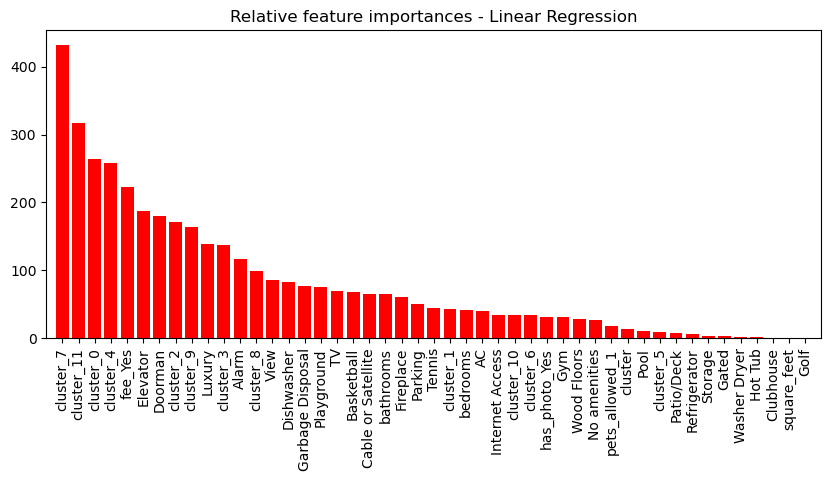

In [41]:
# Plot the feature importances 
plt.figure(figsize=(10, 4))
plt.title("Relative feature importances - Linear Regression")
plt.bar(range(X.shape[1]), importances1[indices],
       color="r",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [42]:
importances2 = np.abs(ridge_benchmark.coef_)  # Take the absolute value of the coefficients
indices = np.argsort(importances2)[::-1]  # Sort the coefficients in descending order of importance

# Get the feature names in order of importance
feature_order = np.array([X.columns.values])
i = np.argsort(importances2)[::-1]
feature_order = feature_order[:, i]

# If you want to print the features sorted by their importance
print("Features ranked by importance:")
for idx in indices:
    print(f"{X.columns[idx]}: {importances2[idx]}")

Features ranked by importance:
cluster_7: 347.46907347332115
cluster_11: 280.1531618295632
cluster_4: 246.41869231602763
cluster_0: 231.3134815617109
Elevator: 184.8421906796517
cluster_2: 149.55347265214505
cluster_9: 148.5653513385934
fee_Yes: 145.37622579714352
Luxury: 124.78589496446064
Doorman: 117.49615474128075
cluster_3: 116.81925312270253
Alarm: 109.86568846482346
Dishwasher: 83.31686753413308
View: 81.70661373373298
cluster_8: 79.7245979019962
Playground: 76.21239039431345
Garbage Disposal: 75.80637521630427
TV: 68.536922603648
Basketball: 66.28008930382178
bathrooms: 64.1897451283557
Cable or Satellite: 64.00969030710391
Fireplace: 60.544608270372265
cluster_10: 53.08505561746883
Parking: 49.94857839192022
Tennis: 44.65575425209234
bedrooms: 41.69061068664761
AC: 40.07225841127389
Internet Access: 34.71748890324036
has_photo_Yes: 31.054919809186373
Gym: 30.807547690715648
cluster_6: 30.163775119644185
Wood Floors: 28.454908521762757
No amenities: 27.102891641901262
pets_allo

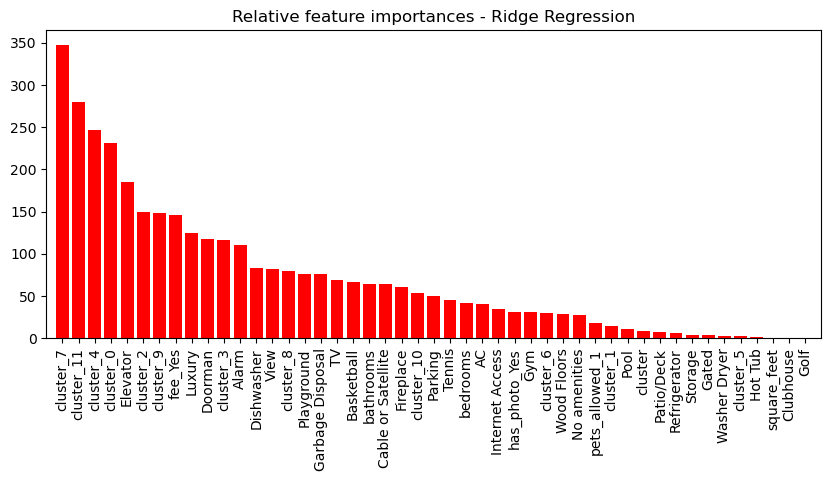

In [43]:
# Plot the feature importances 
plt.figure(figsize=(10, 4))
plt.title("Relative feature importances - Ridge Regression")
plt.bar(range(X.shape[1]), importances2[indices],
       color="r",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()